In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle"

In [ ]:
#!pip install kaggle

In [ ]:
#!kaggle datasets download -d "tawsifurrahman/covid19-radiography-database"

In [ ]:
#!kaggle config set -n path -v /content

In [ ]:
#!ls /content

In [ ]:
#!unzip /content/datasets/tawsifurrahman/covid19-radiography-database/covid19-radiography-database.zip

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32
img_height = 224 #180
img_width = 224 #180
IMAGE_SIZE = (img_height, img_width)

In [ ]:
labels = ['Normal', 'Covid']

In [ ]:
#!mkdir '/content/input'

In [ ]:
#!mv '/content/COVID-19_Radiography_Dataset/COVID/images' '/content/input'
# then rename 'images' folder to 'COVID' manually

In [ ]:
#!mv '/content/COVID-19_Radiography_Dataset/Normal/images' '/content/input'
# then rename 'images' folder to 'Normal' manually

In [ ]:
#!rm -rf '/content/input/.ipynb_checkpoints'

In [ ]:
#base_dir = '/content/input'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 224 files belonging to 2 classes.
Using 180 files for training.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Test/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 2 classes.
Using 32 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Val/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 2 classes.
Using 12 files for validation.


In [ ]:
#class_names = np.array(train_ds.class_names)
#print(class_names)

In [ ]:
class_names = ["Normal", "Covid"]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
numclasses=len(class_names)
def create_model():
    IMAGE_SIZE = (img_height, img_width)
    IMG_SHAPE = IMAGE_SIZE + (3,)
    # EfficientNet can be loaded through efficientnet.tfkeras library (https://github.com/qubvel/efficientnet)
    # pretrained_model = efficientnet.tfkeras.EfficientNetB0(weights='imagenet', include_top=False)
    pretrained_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    
    pretrained_model.trainable = False

    header = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(numclasses, activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
    ])

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = pretrained_model(x, training=False)
    outputs = header(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 sequential_1 (Sequential)   (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import time
start_time = time.time()
EPOCHS=20
history = model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 9s 542ms/step - loss: 0.9097 - accuracy: 0.3167 - val_loss: 0.7644 - val_accuracy: 0.2500
Epoch 2/20
6/6 [==============================] - 2s 271ms/step - loss: 0.8374 - accuracy: 0.3833 - val_loss: 0.7286 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 2s 266ms/step - loss: 0.8109 - accuracy: 0.3611 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 2s 267ms/step - loss: 0.7496 - accuracy: 0.4444 - val_loss: 0.6691 - val_accuracy: 0.6667
Epoch 5/20
6/6 [==============================] - 2s 268ms/step - loss: 0.7096 - accuracy: 0.5111 - val_loss: 0.6434 - val_accuracy: 0.6667
Epoch 6/20
6/6 [==============================] - 2s 271ms/step - loss: 0.6887 - accuracy: 0.5667 - val_loss: 0.6201 - val_accuracy: 0.6667
Epoch 7/20
6/6 [==============================] - 2s 273ms/step - loss: 0.6487 - accuracy: 0.7000 - val_loss: 0.5975 - val_accuracy: 0.5833
Epoch 8/20
6/6 [===============

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 294ms/step - loss: 0.4135 - accuracy: 0.9375


[0.4134751558303833, 0.9375]

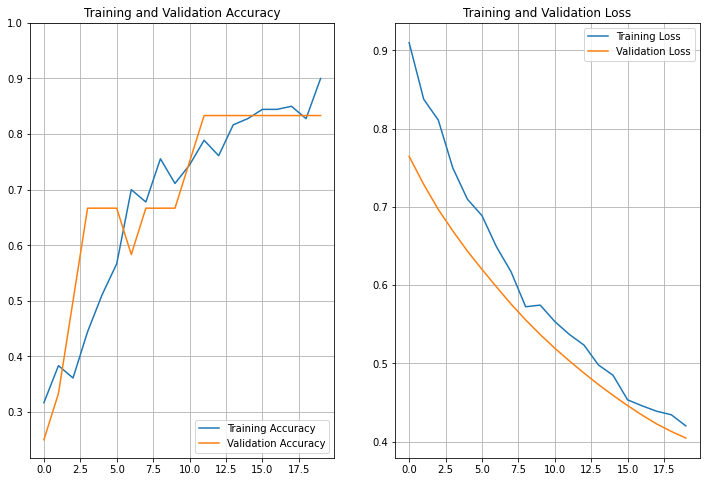

In [ ]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')

plot_history(history, 'accuracy', 'val_accuracy')

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch

array([[0.17379174, 0.82620823],
       [0.23258811, 0.7674118 ],
       [0.66672355, 0.3332765 ],
       [0.20806468, 0.7919353 ],
       [0.18750374, 0.81249624],
       [0.6053327 , 0.3946674 ],
       [0.5750884 , 0.4249117 ],
       [0.16410883, 0.8358912 ],
       [0.46387288, 0.5361271 ],
       [0.24535152, 0.7546485 ],
       [0.41270846, 0.58729154],
       [0.47932875, 0.52067125]], dtype=float32)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpcm016vi0/assets
